Cluster Centers (Year, Duration):
[[2014.26255615  120.82523479]
 [1986.13842975  114.49380165]
 [2016.33364632   81.03067293]]


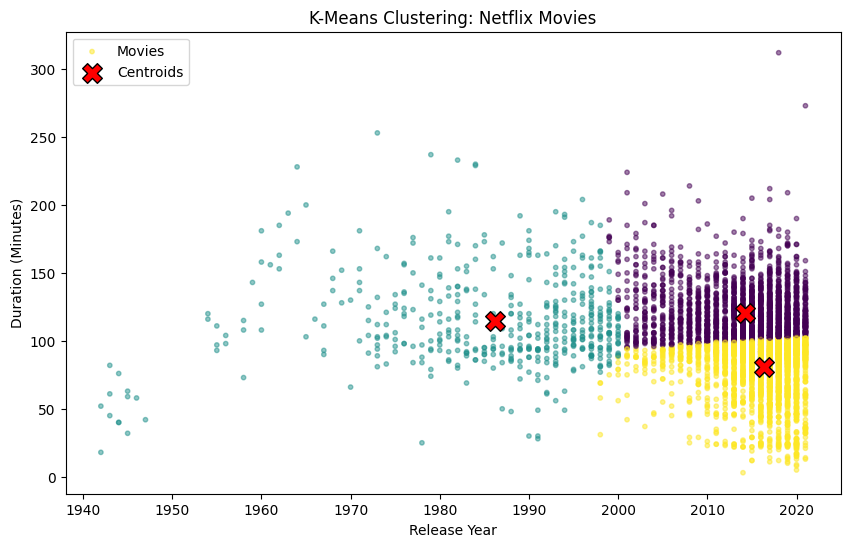

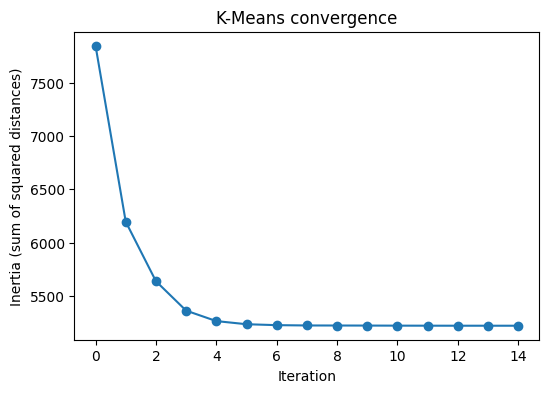

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ------------ 1. Data Preparation ------------

# Load the dataset (change path if needed)
df = pd.read_csv('/content/drive/MyDrive/Datasets/netflix_data.csv')

# Filter for Movies only
df_movies = df[df['type'] == 'Movie'].copy()

# Extract numeric duration (e.g. "90 min" -> 90)
df_movies['duration_min'] = (
    df_movies['duration']
    .str.replace(' min', '', regex=False)
    .astype(float)
)

# Drop rows with missing values in used columns
df_movies = df_movies.dropna(subset=['duration_min', 'release_year'])

# Select features: Year and Duration
features = df_movies[['release_year', 'duration_min']].values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# ------------ 2. K-Means Implementation ------------

def kmeans(X, K, max_iters=100, random_state=42):
    np.random.seed(random_state)
    n_samples, n_features = X.shape

    # Initialize centroids
    idx = np.random.choice(n_samples, K, replace=False)
    centroids = X[idx].astype(float)

    inertia_history = []

    for it in range(max_iters):
        # Assignment step
        sqdist = np.sum((X[:, None, :] - centroids[None, :, :])**2, axis=2)
        labels = np.argmin(sqdist, axis=1)

        # Inertia (sum of squared distances to closest centroid)
        inertia = np.sum([sqdist[i, labels[i]] for i in range(n_samples)])
        inertia_history.append(inertia)

        # Update step
        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            pts = X[labels == k]
            if len(pts) > 0:
                new_centroids[k] = pts.mean(axis=0)
            else:
                # reinitialize empty cluster
                new_centroids[k] = X[np.random.randint(0, n_samples)]

        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids

        if shift < 1e-6:
            break

    return centroids, labels, inertia_history

# ------------ 3. Run the Model ------------

K_clusters = 3
centroids_scaled, hard_labels, inertia_history = kmeans(
    X_scaled, K=K_clusters, max_iters=100, random_state=0
)

# Convert centroids back to original scale (year, minutes)
centroids_original = scaler.inverse_transform(centroids_scaled)

print("Cluster Centers (Year, Duration):")
print(centroids_original)

# ------------ 4. Visualization ------------

plt.figure(figsize=(10, 6))

plt.scatter(
    features[:, 0],
    features[:, 1],
    c=hard_labels,
    cmap='viridis',
    s=10,
    alpha=0.5,
    label='Movies'
)

plt.scatter(
    centroids_original[:, 0],
    centroids_original[:, 1],
    c='red',
    s=200,
    marker='X',
    edgecolors='black',
    label='Centroids'
)

plt.title('K-Means Clustering: Netflix Movies')
plt.xlabel('Release Year')
plt.ylabel('Duration (Minutes)')
plt.legend()
plt.show()

# Optional: plot inertia over iterations
plt.figure(figsize=(6,4))
plt.plot(inertia_history, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Inertia (sum of squared distances)")
plt.title("K-Means convergence")
plt.show()
